In [2]:
import matplotlib.pyplot as plt
plt.style.use("custom_standard")
# plt.style.use("custom_small")
import seaborn as sns
import pandas as pd
import numpy as np
from local_conservation_analysis_pipeline import group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align
import local_seqtools.general_utils as tools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def file_converter(filepath):
    return filepath.replace('/home/jch/Documents/07-pt1_pt2_combined', '../../../')

# final

## note that this is not very elegant

inputs

In [8]:
table_file = "../../../benchmark/benchmark_v3/MSA_comparison/benchmark_table_renamed_MSA_comparison_ANNOTATED.csv"
df = pd.read_csv(table_file)
df = df[df["ELM_motif_class"] != "TRAF6"]
df = df[df["ELM_motif_class"] != "LIG_14-3-3_CanoR_1"]
df = df[
    [
        "reference_index",
        "Organism",
        "Primary_Acc",
        "Accessions",
        "UniprotID",
        "regex",
        "hit_sequence",
        "gene_id",
        "hit start position",
        "hit end position",
        "verified interaction",
        "ELM_motif_class",
        "name",
        "critical_error",
        "json_file",
    ]
]

add position masks

In [9]:
position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "enah_LPPPP_FPPPP": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
}
df['mask_array'] = df["ELM_motif_class"].map(position_weights)

In [10]:
SCOREKEY = "aln_shannon_entropy"
LEVELS = ["Tetrapoda", "Vertebrata", "Metazoa"]
ALLLEVELS = []
for lvl in LEVELS:
    ALLLEVELS.append(lvl)
    ALLLEVELS.append(lvl + '-Muscle')
    ALLLEVELS.append(lvl + '-clustalo')

In [17]:
def json_2_score_list(json_file, level, scorekey, filepath_converter=file_converter):
    if filepath_converter is not None:
        json_file = filepath_converter(json_file)
    og = group_tools.ConserGene(json_file, filepath_converter=filepath_converter)
    try:
        lvlo=og.get_aln_score_obj(level=level, score_key=scorekey, filepath_converter=filepath_converter)
    except KeyError:
        print(json_file)
        return
    return lvlo.hit_scores

In [18]:
for level in ALLLEVELS:
    colname = f"{level}_{SCOREKEY}_scorelist"
    df[colname] = df["json_file"].apply(
        lambda x: json_2_score_list(x, level, SCOREKEY)
    )
cols = [i for i in df.columns if "_scorelist" in i]

../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/428-9606_0_002d5f/428-9606_0_002d5f.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/436-10116_0_001079/436-10116_0_001079.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/808-9606_0_0030e7/808-9606_0_0030e7.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/809-9606_0_0030e7/809-9606_0_0030e7.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/1120-9606_0_0017ce/1120-9606_0_0017ce.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/1433-9606_0_004b09/1433-9606_0_004b09.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/1436-9606_0_0036d0/1436-9606_0_0036d0.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/1451-9606_0_00121c/1451-9606_0_00121c.json
../../..//benchmark/benchmark_v3/MSA_comparison/conservation_analysis/1498-9606_0_00378e/1498-9606_0_0

In [19]:
df[cols].isna().sum()

Tetrapoda_aln_shannon_entropy_scorelist              18
Tetrapoda-Muscle_aln_shannon_entropy_scorelist       18
Tetrapoda-clustalo_aln_shannon_entropy_scorelist     18
Vertebrata_aln_shannon_entropy_scorelist              0
Vertebrata-Muscle_aln_shannon_entropy_scorelist       0
Vertebrata-clustalo_aln_shannon_entropy_scorelist     0
Metazoa_aln_shannon_entropy_scorelist                 0
Metazoa-Muscle_aln_shannon_entropy_scorelist          0
Metazoa-clustalo_aln_shannon_entropy_scorelist        0
dtype: int64

The missing Tetrapoda scores are because the homolog groups contained less than 20 sequences <br>
We will just remove those entries entirely

In [20]:
ol = len(df)
df = df.dropna(how='any', axis=0, subset=cols).copy()
nl = len(df)
print(f'removed {ol-nl} entries from table')
print(f'{nl} remaining SLiMs')

removed 18 entries from table
236 remaining SLiMs


In [21]:
df[cols].isna().sum()

Tetrapoda_aln_shannon_entropy_scorelist              0
Tetrapoda-Muscle_aln_shannon_entropy_scorelist       0
Tetrapoda-clustalo_aln_shannon_entropy_scorelist     0
Vertebrata_aln_shannon_entropy_scorelist             0
Vertebrata-Muscle_aln_shannon_entropy_scorelist      0
Vertebrata-clustalo_aln_shannon_entropy_scorelist    0
Metazoa_aln_shannon_entropy_scorelist                0
Metazoa-Muscle_aln_shannon_entropy_scorelist         0
Metazoa-clustalo_aln_shannon_entropy_scorelist       0
dtype: int64

In [22]:
def check_list(l):
    if not isinstance(l, list):
        return False
    for i in l:
        if not isinstance(i, float):
            return False
    return True

for col in cols:
    df[f'{col}_check'] = df[col].apply(check_list)

for col in cols:
    assert (df[f'{col}_check'] == True).all(), 'there are issues with the score lists'

In [23]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

for col in cols:
    df[f'{col}_masked'] = df.apply(
        lambda x: extract_important_scores(x, col), axis=1
    )
df['hit_sequence_residues'] = df['hit_sequence'].apply(list)
df['hit_sequence_residues_masked'] = df.apply(
    lambda x: extract_important_scores(x, 'hit_sequence_residues'), axis=1
)

In [24]:
masked_cols=[f'{col}_masked' for col in cols]
# explode the list of scores into individual rows
weighted_residue_score_df = df.explode(masked_cols+['hit_sequence_residues_masked'])
# make sure it did what we expected
test = weighted_residue_score_df.loc[296]
for aa,score in zip(test["hit_sequence"].iloc[0],test["Metazoa_aln_shannon_entropy_scorelist"].iloc[0]):
    print(aa,score)
print('-----')
for aa, score in zip(test['hit_sequence_residues_masked'],test["Metazoa_aln_shannon_entropy_scorelist_masked"]):
    print(aa, score)

L 0.18521311488742212
P 0.29992834377878475
P 0.35059962855879995
P 0.3657756650026588
P 0.6717172540264424
-----
L 0.18521311488742212
P 0.29992834377878475
P 0.3657756650026588
P 0.6717172540264424


In [25]:
weighted_residue_score_df = weighted_residue_score_df[
    [
        "reference_index",
        "regex",
        "hit_sequence",
        "gene_id",
        "ELM_motif_class",
        "name",
        "json_file",
        "mask_array",
        "hit_sequence_residues_masked"
    ]
    +
    masked_cols
].copy()
weighted_residue_score_df['ELM_motif_class'] = weighted_residue_score_df['ELM_motif_class'].replace('enah_LPPPP_FPPPP', 'Ena/VASP ([FL]PPPP)')

In [26]:
print(len(weighted_residue_score_df))

721


In [27]:
def make_scatterplots(dfin, level, scorekey):
    colname_dict={
        f"{level}_{scorekey}_scorelist_masked": "Mafft",
        f"{level}-Muscle_{scorekey}_scorelist_masked": "Muscle",
        f"{level}-clustalo_{scorekey}_scorelist_masked": "clustalo",
    }
    filter_cols = list(colname_dict.keys())
    filter_cols.append("ELM_motif_class")
    df = dfin[filter_cols].copy()
    df=df.rename(columns=colname_dict)
    df=df.rename(columns={"ELM_motif_class": "motif"})
    fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
    sns.scatterplot(
        x="Mafft",
        y="clustalo",
        hue="motif",
        data=df,
        alpha=0.5,
        ax=axes[0],
    )
    sns.scatterplot(
        x="Mafft",
        y="Muscle",
        hue="motif",
        data=df,
        alpha=0.5,
        ax=axes[1],
    )
    sns.scatterplot(
        x="clustalo",
        y="Muscle",
        hue="motif",
        data=df,
        alpha=0.5,
        ax=axes[2],
    )
    for ax in axes:
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.tight_layout()

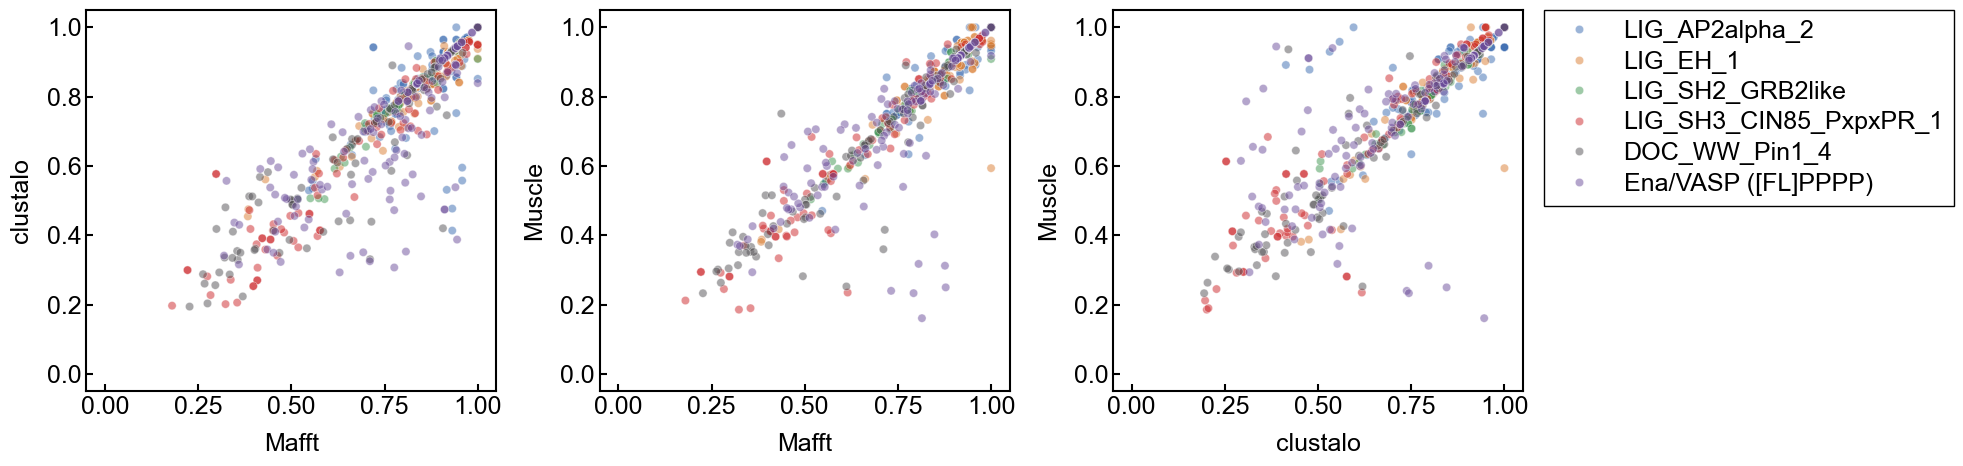

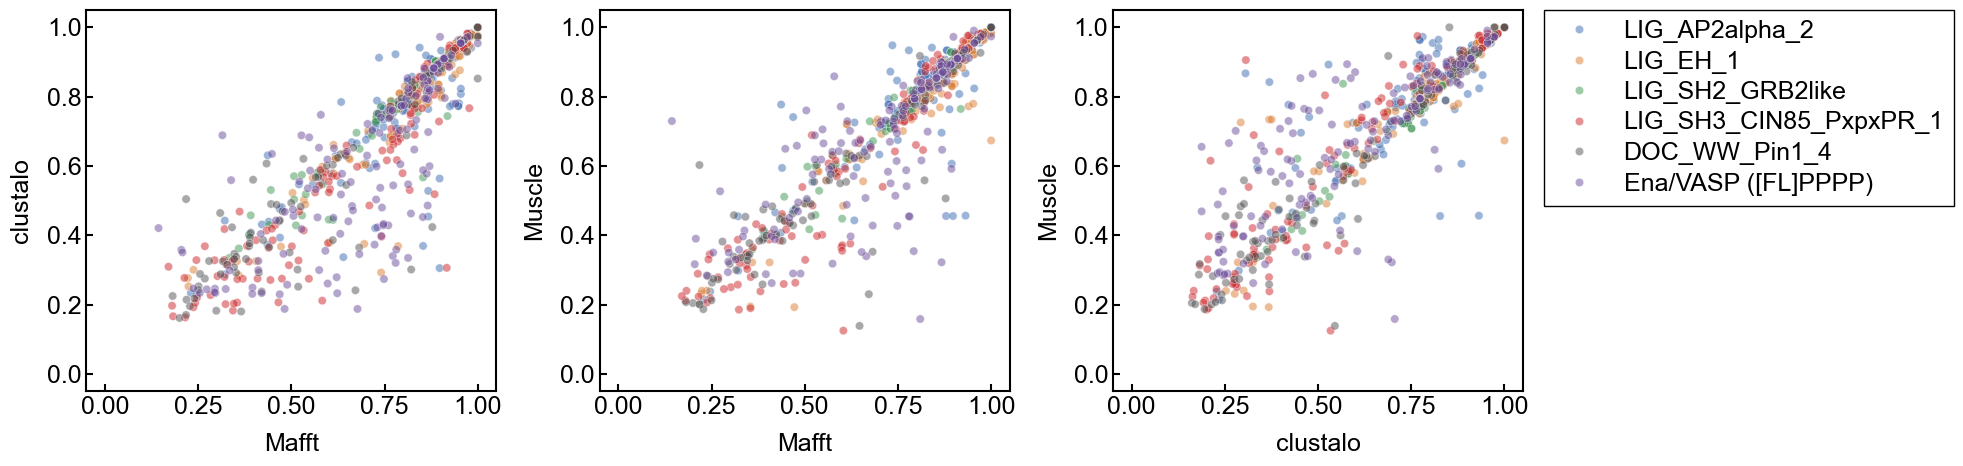

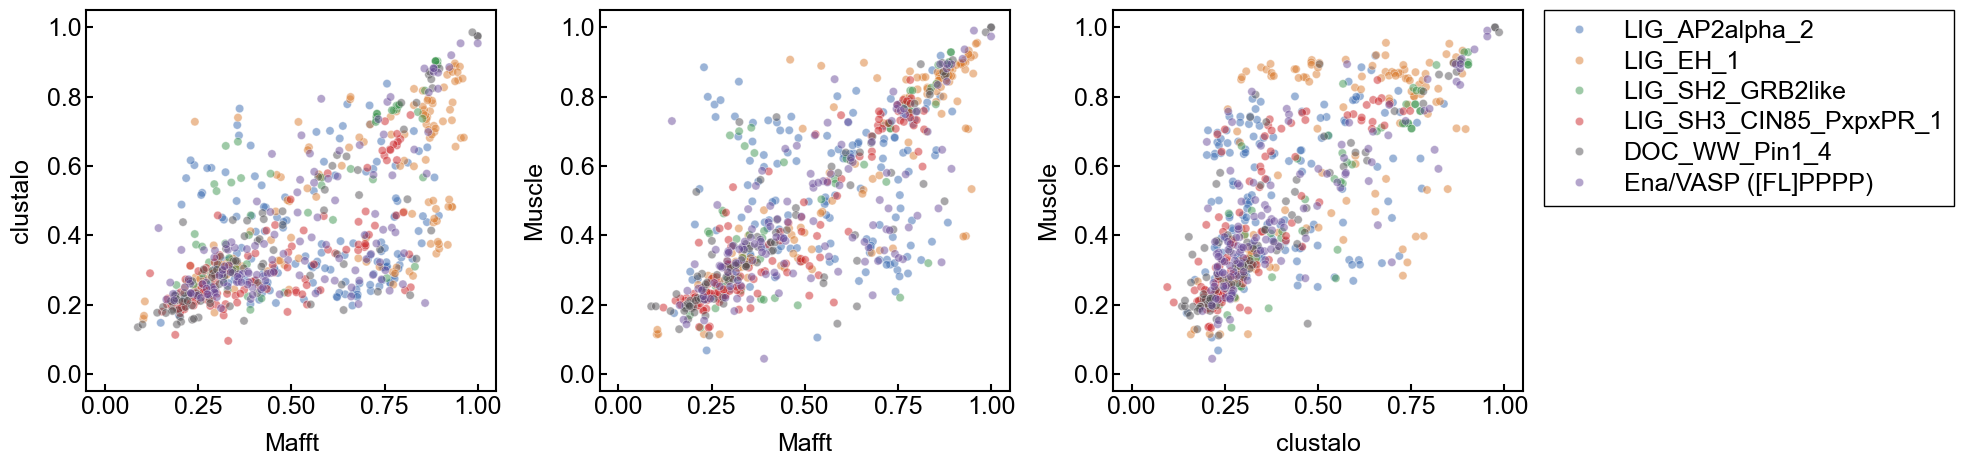

In [28]:
supp_output=Path('../../supplement/MSA_correlation_levels/')
for level in LEVELS:
    make_scatterplots(weighted_residue_score_df, level, SCOREKEY)
    plt.savefig(f"./SLiM_residue_MSA_correlation-{level}.png", dpi=400)
    plt.savefig(supp_output / f"SLiM_residue_MSA_correlation-{level}.png", dpi=400)

In [29]:
print(weighted_residue_score_df.reference_index.nunique())

236


In [34]:
print(len(weighted_residue_score_df['Metazoa_aln_shannon_entropy_scorelist_masked']))

721


# development

In [4]:
table_file = "../../../benchmark/benchmark_v3/MSA_comparison/benchmark_table_renamed_MSA_comparison_ANNOTATED.csv"
df = pd.read_csv(table_file)
df = df[df["ELM_motif_class"] != "TRAF6"]
df = df[df["ELM_motif_class"] != "LIG_14-3-3_CanoR_1"]
df = df[
    [
        "reference_index",
        "Organism",
        "Primary_Acc",
        "Accessions",
        "UniprotID",
        "regex",
        "hit_sequence",
        "gene_id",
        "hit start position",
        "hit end position",
        "verified interaction",
        "ELM_motif_class",
        "name",
        "critical_error",
        "json_file",
    ]
]

In [5]:
position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "enah_LPPPP_FPPPP": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
}
df['mask_array'] = df["ELM_motif_class"].map(position_weights)

In [4]:
# df[df["Metazoa_hit_mean_zscore"].isna()][["Metazoa_hit_mean_zscore", "Metazoa_hit_mean_score"]]
temp=df.loc[119]
og = group_tools.ConserGene(temp["json_file"])
og.load_levels()
lvlaln=og.get_aln_score_obj('Metazoa', 'aln_shannon_entropy')
print('z score failed')
print(lvlaln.z_score_failure)
print('but normal alignment scores are okay and that is what we are using for the plot')
for aa, s in zip(lvlaln.hit_aln_sequence, lvlaln.hit_aln_scores):
    print(aa, s)

z score failed
not enough background scores to calculate z-score. Require at least 20 background scores. Only have 18 background scores
but normal alignment scores are okay and that is what we are using for the plot
Y 0.2605673210467785
S 0.22008868075119684
N 0.390024227260842
A 0.158882506177099


In [6]:
for level, lvlo in og.level_objects.items():
    print(lvlo.conservation_scores[SCOREKEY]['file'])
    for scorekey in lvlo.conservation_scores:
        print(level, scorekey)

/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/MSA_comparison/conservation_analysis/806-9606_0_0016a6/806-Vertebrata-aln_shannon_entropy.json
Vertebrata aln_property_entropy
Vertebrata aln_shannon_entropy
/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/MSA_comparison/conservation_analysis/806-9606_0_0016a6/806-Vertebrata-Muscle-aln_shannon_entropy.json
Vertebrata-Muscle aln_property_entropy
Vertebrata-Muscle aln_shannon_entropy
/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/MSA_comparison/conservation_analysis/806-9606_0_0016a6/806-Vertebrata-clustalo-aln_shannon_entropy.json
Vertebrata-clustalo aln_property_entropy
Vertebrata-clustalo aln_shannon_entropy
/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/MSA_comparison/conservation_analysis/806-9606_0_0016a6/806-Metazoa-aln_shannon_entropy.json
Metazoa aln_property_entropy
Metazoa aln_shannon_entropy
/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/MSA_comparison

In [5]:
SCOREKEY = "aln_shannon_entropy"
LEVEL = "Metazoa"

### add score lists to the dataframe

In [7]:
def json_2_score_list(json_file, level, scorekey):
    og = group_tools.ConserGene(json_file)
    lvlo=og.get_aln_score_obj(level=level, score_key=scorekey)
    return lvlo.hit_scores

In [8]:
for level in og.levels_passing_filters:
    if LEVEL not in level:
        continue
    colname = f"{level}_{SCOREKEY}_scorelist"
    df[colname] = df["json_file"].apply(
        lambda x: json_2_score_list(x, level, SCOREKEY)
    )

In [10]:
cols = [i for i in df.columns if "_scorelist" in i]

check to make sure that there are no weird or missing values in the lists

In [11]:
def check_list(l):
    if not isinstance(l, list):
        return False
    for i in l:
        if not isinstance(i, float):
            return False
    return True

for col in cols:
    df[f'{col}_check'] = df[col].apply(check_list)

for col in cols:
    assert (df[f'{col}_check'] == True).all(), 'there are issues with the score lists'

0
0
0


In [13]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]


for col in cols:
    df[f'{col}_masked'] = df.apply(
        lambda x: extract_important_scores(x, col), axis=1
    )
df['hit_sequence_residues'] = df['hit_sequence'].apply(list)
df['hit_sequence_residues_masked'] = df.apply(
    lambda x: extract_important_scores(x, 'hit_sequence_residues'), axis=1
)
# df[cols[0]].apply(len)
# df[cols[0]+"_masked"].apply(len)
print(df.groupby("ELM_motif_class").first()[cols[0]].apply(len))
print(df.groupby("ELM_motif_class").first()[cols[0]+"_masked"].apply(len))

ELM_motif_class
DOC_WW_Pin1_4             6
LIG_AP2alpha_2            3
LIG_EH_1                  5
LIG_SH2_GRB2like          4
LIG_SH3_CIN85_PxpxPR_1    6
enah_LPPPP_FPPPP          5
Name: Metazoa_aln_shannon_entropy_scorelist, dtype: int64
ELM_motif_class
DOC_WW_Pin1_4             2
LIG_AP2alpha_2            3
LIG_EH_1                  3
LIG_SH2_GRB2like          3
LIG_SH3_CIN85_PxpxPR_1    4
enah_LPPPP_FPPPP          4
Name: Metazoa_aln_shannon_entropy_scorelist_masked, dtype: int64


In [14]:
masked_cols=[f'{col}_masked' for col in cols]

# explode the list of scores into individual rows
weighted_residue_score_df = df.explode(masked_cols+['hit_sequence_residues_masked'])

# make sure it did what we expected
test = weighted_residue_score_df.loc[296]
for aa,score in zip(test["hit_sequence"].iloc[0],test["Metazoa_aln_shannon_entropy_scorelist"].iloc[0]):
    print(aa,score)
print('-----')
for aa, score in zip(test['hit_sequence_residues_masked'],test["Metazoa_aln_shannon_entropy_scorelist_masked"]):
    print(aa, score)

L 0.18521311488742212
P 0.29992834377878475
P 0.35059962855879995
P 0.3657756650026588
P 0.6717172540264424
-----
L 0.18521311488742212
P 0.29992834377878475
P 0.3657756650026588
P 0.6717172540264424


In [15]:
weighted_residue_score_df = weighted_residue_score_df[[
    "reference_index",
    "regex",
    "hit_sequence",
    "gene_id",
    "ELM_motif_class",
    "name",
    "json_file",
    "mask_array",
    "hit_sequence_residues_masked",
    "Metazoa_aln_shannon_entropy_scorelist_masked",
    "Metazoa-Muscle_aln_shannon_entropy_scorelist_masked",
    "Metazoa-clustalo_aln_shannon_entropy_scorelist_masked",
]]
weighted_residue_score_df = weighted_residue_score_df.rename(
    columns={
        "ELM_motif_class": "motif",
        "Metazoa_aln_shannon_entropy_scorelist_masked": "Mafft",
        "Metazoa-Muscle_aln_shannon_entropy_scorelist_masked": "Muscle",
        "Metazoa-clustalo_aln_shannon_entropy_scorelist_masked": "clustalo",
    }
)

---

check to make sure that there are no weird or missing values in the lists

In [14]:
def check_list(l):
    if not isinstance(l, list):
        return False
    for i in l:
        if not isinstance(i, float):
            return False
    return True

for col in cols:
    df[f'{col}_check'] = df[col].apply(check_list)

for col in cols:
    print(len(df[df[f'{col}_check'] == False]))

0
0
0


In [20]:
# add a column with the standard deviation of the 3 columns
weighted_residue_score_df["std"] = weighted_residue_score_df[["Mafft", "Muscle", "clustalo"]].std(axis=1)

<Axes: >

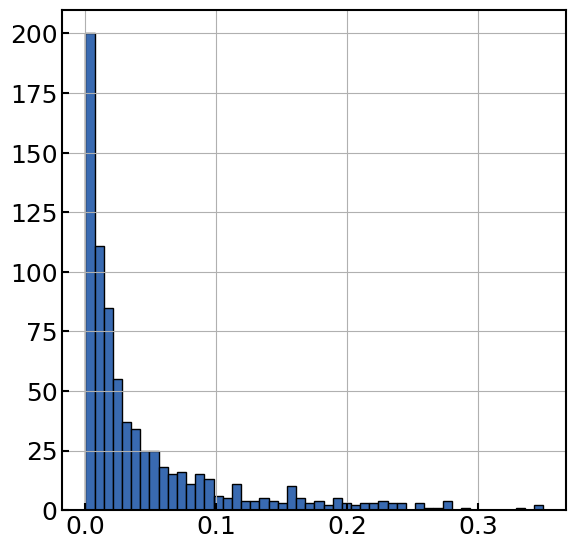

In [23]:
weighted_residue_score_df["std"].hist(bins=50)

In [27]:
weighted_residue_score_df_longform = weighted_residue_score_df.melt(
    id_vars=[
        'reference_index',
        'regex',
        'hit_sequence',
        'gene_id',
        'motif',
        'name',
        'json_file',
        'mask_array',
        'hit_sequence_residues_masked',
    ],
    value_vars=["Mafft", "Muscle", "clustalo"],
    var_name="alignment",
    value_name="score",
)

In [ ]:
grid = sns.FacetGrid(weighted_residue_score_df, col="alignment", hue="motif", col_wrap=3, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

In [ ]:

df.groupby("ELM_motif_class").first()["regex"]
position_weights = {
    "DOC_WW_Pin1_4": [0, 0, 0, 1, 1, 0],  # ...([ST])P.
    "LIG_AP2alpha_2": [1, 1, 1],  # DP[FW]
    "LIG_EH_1": [0, 1, 1, 1, 0],  # .NPF.
    "LIG_SH2_GRB2like": [1, 1, 1, 0],  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": [1, 0, 1, 0, 1, 1],  # P.[AP].PR
    "enah_LPPPP_FPPPP": [1, 1, 0, 1, 1],  # [FWYL]P.[AFILTVYWP]P
}# could use this for a weighted average score

weighted_residue_score_df = pd.DataFrame(
    columns=["motif", "AA", "Muscle", "clustalo", "Mafft"]
)
ind_counter = 0
for i, row in df.iterrows():
    motif = row["ELM_motif_class"]
    w = position_weights[motif]
    position = 0
    for muscle_score, clustal_score, mafft_score, aa in zip(
        row[f'{LEVEL}-Muscle_{SCOREKEY}_scorelist'],# muscle
        row[f'{LEVEL}-clustalo_{SCOREKEY}_scorelist'],# clustal
        row[f'{LEVEL}_{SCOREKEY}_scorelist'],# mafft
        row["hit_sequence"],
    ):
        if w[position] == 1:
            weighted_residue_score_df.loc[ind_counter] = [
                motif,
                aa,
                muscle_score,
                clustal_score,
                mafft_score,
            ]
        ind_counter += 1
        position += 1

weighted_residue_score_long = weighted_residue_score_df.melt(
    id_vars=["motif", "AA"],
    value_vars=["Muscle", "clustalo", "Mafft"],
    var_name="aligner",
    value_name="score",
)

<Axes: xlabel='AA', ylabel='Muscle'>

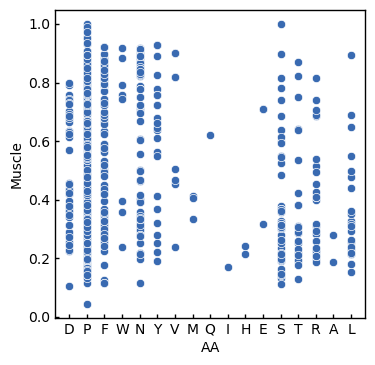

In [ ]:
sns.scatterplot(weighted_residue_score_df, x="AA", y="Muscle")

In [ ]:



weighted_residue_score_df = pd.DataFrame(
    columns=["motif", "AA", "Muscle", "clustalo", "Mafft"]
)
ind_counter = 0
for i, row in df.iterrows():
    motif = row["ELM_motif_class"]
    w = position_weights[motif]
    position = 0
    for muscle_score, clustal_score, mafft_score, aa in zip(
        row[f'{LEVEL}-Muscle_{SCOREKEY}_scorelist'],# muscle
        row[f'{LEVEL}-clustalo_{SCOREKEY}_scorelist'],# clustal
        row[f'{LEVEL}_{SCOREKEY}_scorelist'],# mafft
        row["hit_sequence"],
    ):
        if w[position] == 1:
            weighted_residue_score_df.loc[ind_counter] = [
                motif,
                aa,
                muscle_score,
                clustal_score,
                mafft_score,
            ]
        ind_counter += 1
        position += 1

weighted_residue_score_long = weighted_residue_score_df.melt(
    id_vars=["motif", "AA"],
    value_vars=["Muscle", "clustalo", "Mafft"],
    var_name="aligner",
    value_name="score",
)

In [105]:
mask = np.array([1,1,1,0])
x = np.array([1,2,3,4])
# mask the x array
x[mask.nonzero()]

array([1, 2, 3])

In [106]:
np.array(mask)

array([1, 1, 1, 0])

In [74]:
np.array(df.loc[119][cols[0]])[np.array([bool(i) for i in [1,1,1,0]])]
# np.where

array([0.26056732, 0.22008868, 0.39002423])

In [ ]:
from ast import literal_eval
from collections import defaultdict

df["ELM_motif_class"].value_counts()

cols = [i for i in df.columns if "hit_scores" in i]
for col in cols:
    df[col] = df[col].apply(literal_eval)

In [ ]:

n_mots = len(df["ELM_motif_class"].unique())
# n_cols = 3
# n_rows = int(np.ceil(n_mots/n_cols))
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
mos_vector = [
    [f"distribution-{n}"] + [f"Muscle-{n}"] + [f"clustalo-{n}"] for n in range(n_mots)
]
fig, axd = plt.subplot_mosaic(mos_vector, figsize=(8, 20), layout="constrained")

for c, motif in enumerate(df["ELM_motif_class"].unique()):
    temp = df[df["ELM_motif_class"] == motif]
    # ax = axs[int(c/n_cols), c%n_cols]
    axdist = axd[f"distribution-{c}"]
    # bins = np.linspace(-3, 3, 20)
    bins = np.linspace(0, 1, 10)
    # bins = 20
    axdist.hist(
        temp["Metazoa_hit_mean_score"],
        bins=bins,
        # alpha=0.5,
        label="Mafft",
        histtype="bar",
        linewidth=1,
    )
    axdist.hist(
        temp["Metazoa-clustalo_hit_mean_score"],
        bins=bins,
        # alpha=0.5,
        label="clustalo",
        histtype="step",
        linewidth=2,
    )
    axdist.hist(
        temp["Metazoa-Muscle_hit_mean_score"],
        bins=bins,
        # alpha=0.5,
        label="Muscle",
        histtype="step",
        linewidth=2,
    )
    axm = axd[f"Muscle-{c}"]
    axm.plot(temp["Metazoa_hit_mean_score"], temp["Metazoa-Muscle_hit_mean_score"], ".")
    axm.set_xlabel("Mafft")
    axm.set_ylabel("Muscle")
    axm.set_title(motif)
    axm.set_xlim(0, 1)
    axm.set_ylim(0, 1)
    axclu = axd[f"clustalo-{c}"]
    axclu.plot(
        temp["Metazoa_hit_mean_score"],
        temp["Metazoa-clustalo_hit_mean_score"],
        ".",
    )
    axclu.set_xlabel("Mafft")
    axclu.set_ylabel("clustalo")
    axclu.set_xlim(0, 1)
    axclu.set_ylim(0, 1)
plt.show()